In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, lfilter, freqz
from scipy.io import wavfile
from librosa import load
from librosa.core import amplitude_to_db
import time
from scipy.ndimage.filters import gaussian_filter, median_filter
import os
import random

In [8]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, fs = 10):
    order = 1
    cutoff = 4 #3.667  # desired cutoff frequency of the filter, Hz

    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [3]:
def max_consecutive_ones(array):
    '''
    Find max consecutive ones in array
    
    Find the length of the maximum run of
    consecutive 1s in an np array
    
    Args:
        array
    Returns:
        length of maximum run of consecutive 1s
    '''
    return max([len(s) - 1 
                for s in np.split(array, np.where(array == 0.)[0][1:])])

def plot_samples_thresholds(plot_ax, ref_ax, xs, ys, title, thresh, ylim):
    '''
    Plot samples and threshold values on an axis
    
    In a plot with shape (x, 1), plot samples array on 
    a subplot axis, plot_ax, sized to match the position and
    width of the top subplot axis, ref_ax.
    
    Args:
        plot_ax (matplotlib axis): axis to plot on
        ref_ax (matplotlib axis): reference axis to plot beneath.
            assumes that plot_ax and ref_ax share x axis.
        xs (np.ndarray): x values for samples array
        ys (np.ndarray): samples array
        title (str): desired title of plot
    '''
    
    # Plot samples
    plot_ax.plot(xs, ys)

    # Positioning and title
    pos0 = ref_ax.get_position(original=False)
    pos1 = plot_ax.get_position(original=False)
    plot_ax.set_position([pos0.x0, pos1.y0, pos0.width, pos1.height])
    plot_ax.set_ylim(ylim)
    plot_ax.set_title(title)
    
    # Make hlines
    max_y = max(ys)
    if type(thresh) != list:
        thresh = [thresh]
    for idx, t_val in enumerate(thresh):
        if max_y >= t_val:
            plot_ax.axhline(t_val, color = 'r')
        else:
            plot_ax.axhline(t_val)
        


def binarize_thresh(samples_db, thresh):
    '''
    Binarize an array at a threshold
    
    Binarize an np.ndarray such that numbers 
    in it above or equal to the threshold 
    are changed to 1 and numbers below the
    threshold are changed to 0.
    
    Args:
        samples_db (np.ndarray): array to binarize
        thresh (float): threshold for binarization
    '''
    # Find percentage above threshold
    samples = samples_db.copy()
    samples[samples >= thresh] = 1
    samples[samples < thresh] = 0
    #print(f'percentage above threshold {thresh}:', (sum(samples)*100)/len(samples))
    
    return samples

def binarize_thresh_window(samples_db, thresh, nperseg, noverlap):
    '''
    Binarize an array in windows at a threshold
    
    Split an np.ndarray into windows of specified
    size and overlap, calculate the energy in the window,
    then change to 1 if energy meets or exceeds 
    threshold, 0 if not.
    '''

    def _energy(samples_db):
        r = np.sum(samples_db)/float(len(samples_db))
        return r
    
    binarized = []
    
    skip = nperseg - noverlap
    for start in range(0, len(samples_db), skip):
        # Calculate energy in each window
        window_energy = _energy(samples_db[start : start + nperseg])
        # Binarize
        binarized.append(0 if window_energy < thresh else 1)
        
    #print(max_consecutive_ones(binarized))
    
    return binarized
    

def window_energy(nperseg, noverlap, samples = None):
    '''

    '''
    
    def _energy(samples):
        return np.sum(samples**2)/len(samples)
    
    windowed = []

    skip = nperseg - noverlap
    for start in range(0, len(samples), skip):
        # Calculate energy in each window
        window_energy = _energy(samples[start : start + nperseg])
        windowed.append(window_energy)

    #print(max_consecutive_ones(binarized))

    return windowed
    
    

def sample_chunk(samples, start, duration, sample_rate):
    start_sample = int(start*sample_rate)
    dur_sample = int(duration*sample_rate)
    return samples[start_sample : start_sample + dur_sample]

In [4]:
def plot_spect(plot_ax, samples, sample_rate, nperseg, noverlap, title):
    samples_db = amplitude_to_db(samples)
    frequencies, times, spect = spectrogram(
        x = samples_db,
        fs = sample_rate,
        nperseg = nperseg,
        noverlap = noverlap
    )
    plot_ax.pcolormesh(times, frequencies, spect)
    plot_ax.imshow(np.log(spect)[::-1])
    plot_ax.set_title(title)
    
    return spect

In [5]:
def soft_filter(samples):
    fc = 0.1  # Cutoff frequency as a fraction of the sampling rate (in (0, 0.5)).
    b = 0.08  # Transition band, as a fraction of the sampling rate (in (0, 0.5)).
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1  # Make sure that N is odd.
    n = np.arange(N)

    # Compute sinc filter.
    h = np.sinc(2 * fc * (n - (N - 1) / 2))

    # Compute Blackman window.
    w = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + \
        0.08 * np.cos(4 * np.pi * n / (N - 1))

    # Multiply sinc filter by window.
    h = h * w

    # Normalize to get unity gain.
    h = h / np.sum(h)
    
    s = np.convolve(samples, h)



In [15]:
def plot_spect(samples, sr, ax, title):
    f, t, spect = spectrogram(x = samples, fs = sr)
    ax.pcolormesh(t, f, spect)
    ax.imshow(np.log(spect)[::-1])
    ax.set_title(title)
    
    return f, t, spect

/Users/ter38/.conda/envs/birds/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


2.754469156265259


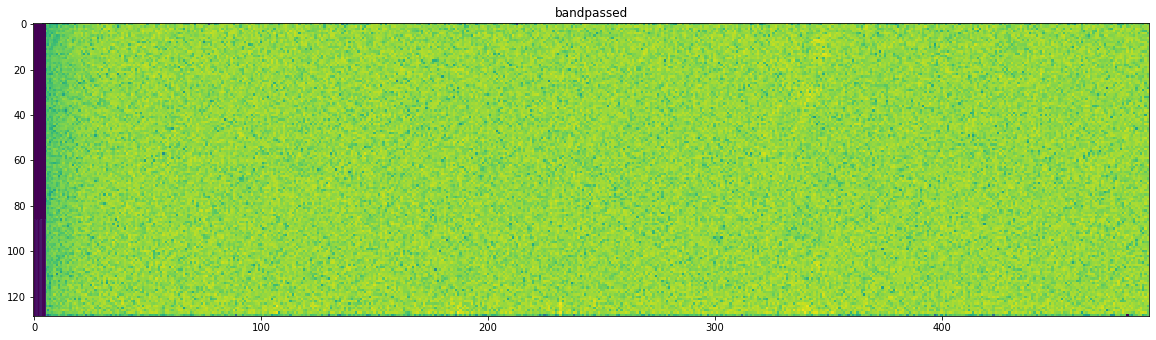

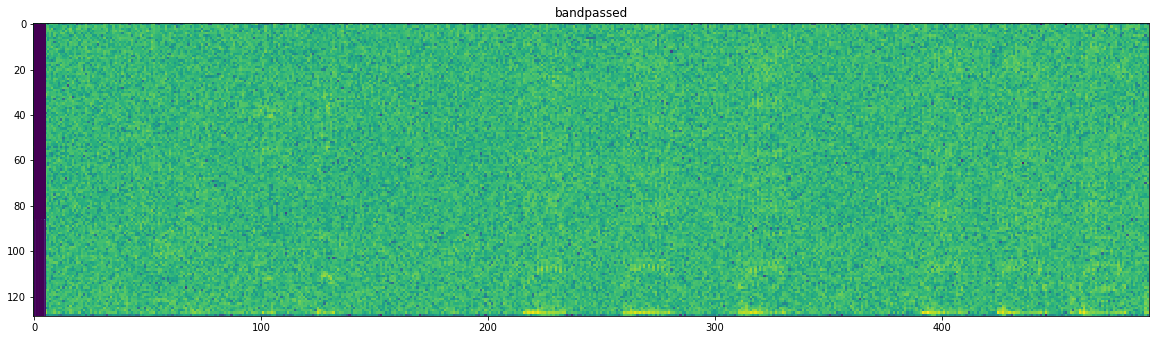

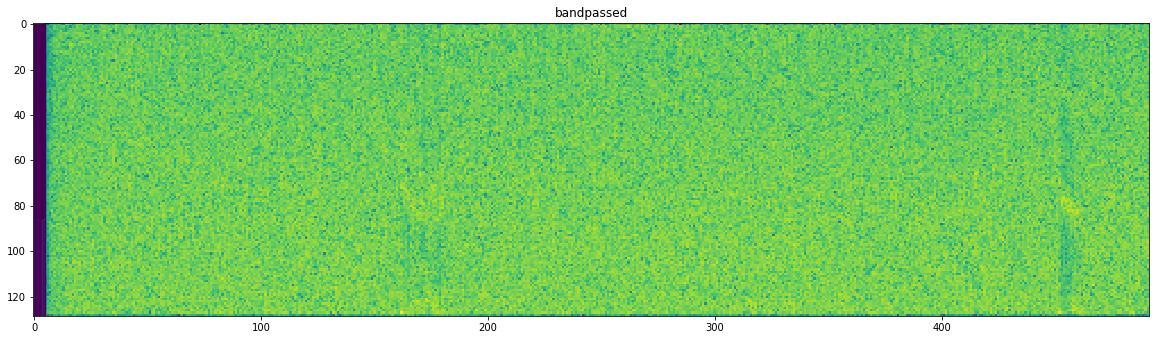

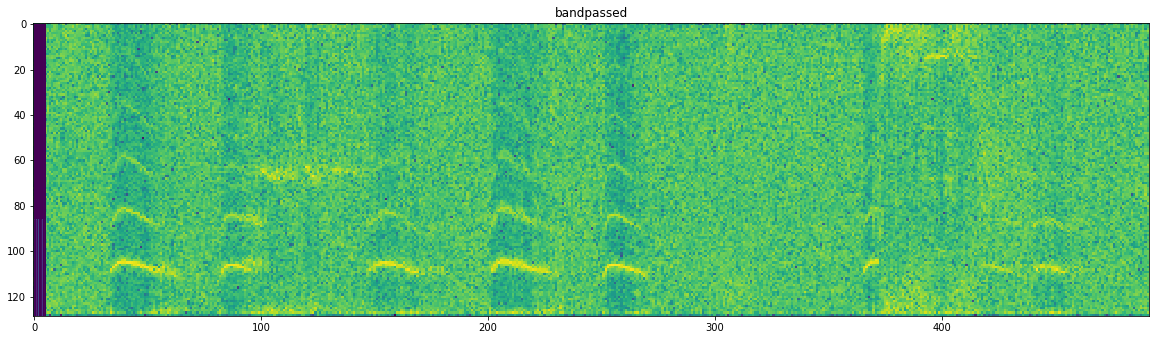

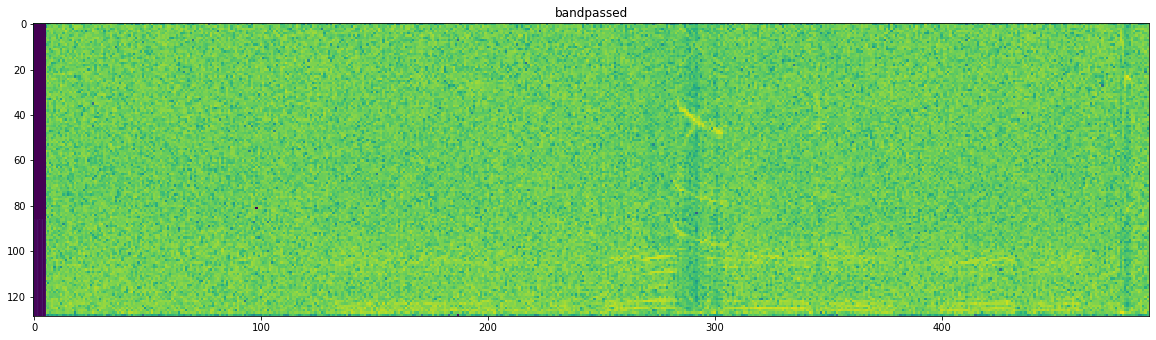

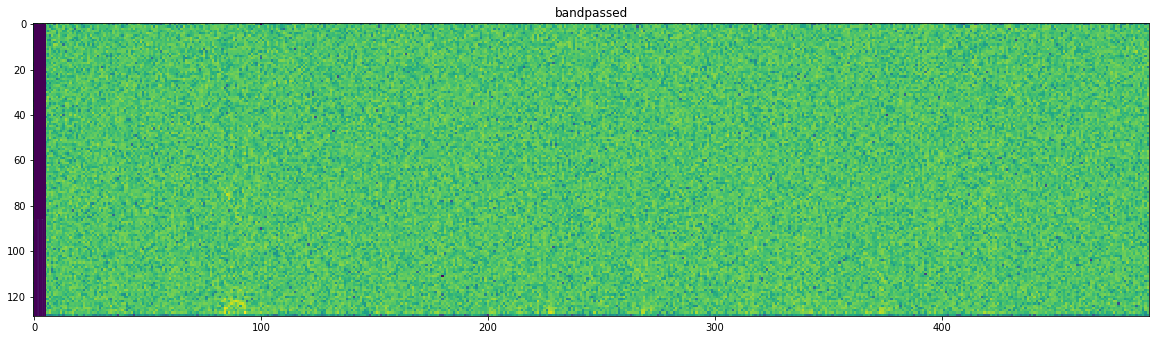

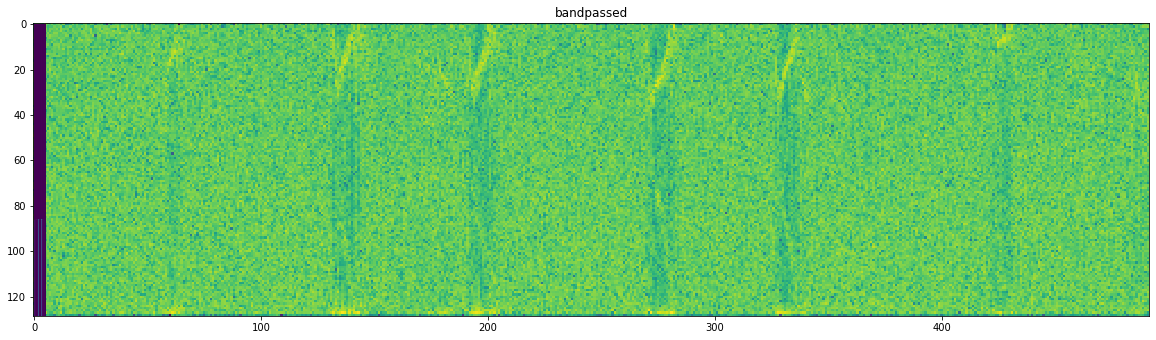

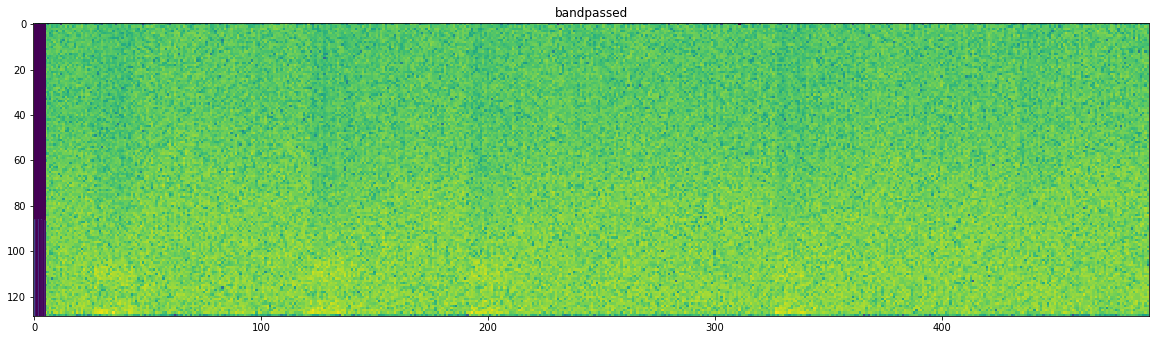

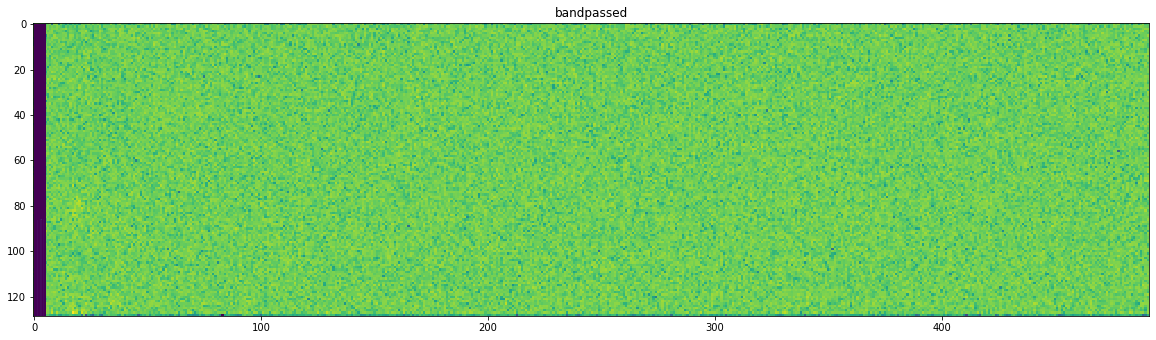

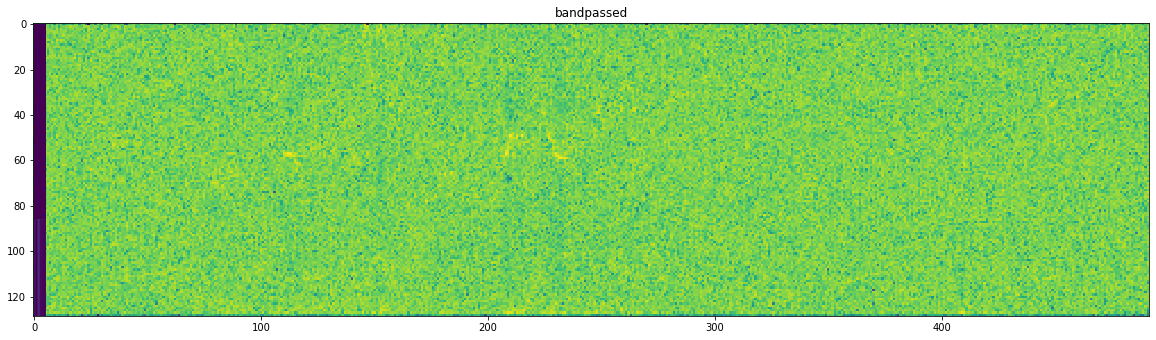

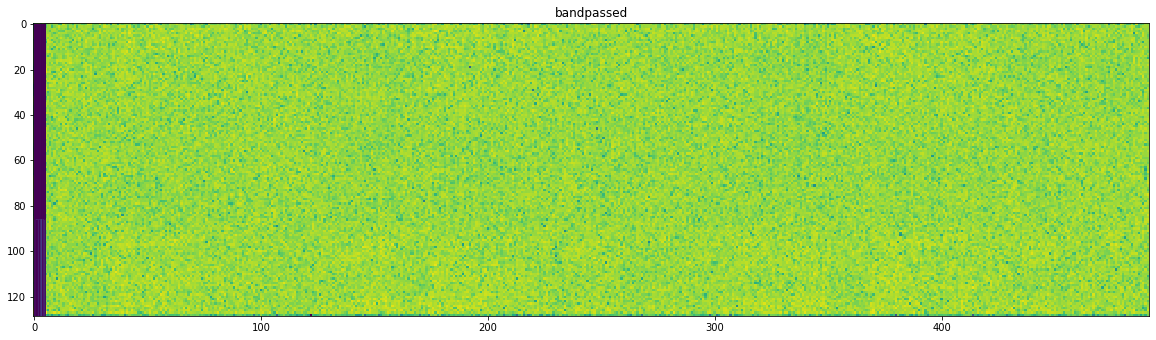

In [18]:
def plot_file(
    filename,
    thresh,
    duration = 5,
    smoothing_factor = 30,
    method = 'avg',
    nperseg = 256,
    noverlap = 0,
    ylim = (-100, 50)
):
    '''
    Plot a spectrogram and decibel information
    
    Plot a spectrogram and below it plot
    a display of which columns of the spectrogram
    include values over a threshold, thresh.
    Multiple plots can be plotted by passing
    a list to thresh.
    
    Args:
        filename: spectrogram to plot
        thresh (float or list): thresholds
            to plot beneath spectrogram. If float,
            plots one. If list, plots many.
    '''
    
    # Find average of whole file
    #samples, sample_rate = load(filename, sr=22050)
    
    #smoothed_samples = gaussian_filter(np.abs(samples), sigma = smoothing_factor)
    '''    smoothed_samples = window_energy(
        samples = samples,
        nperseg = nperseg*smoothing_factor,
        noverlap = noverlap,
    )'''
    
    # Create 5s highpassed spectrogram plot
    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(20, 10))
    samples_5s, sample_rate = load(filename, duration = 5)
    #samples_5s = sample_chunk(samples, start=0, duration=duration, sample_rate=sample_rate)

    samples_5s_highpassed = butter_highpass_filter(data = samples_5s)
    samples_db_5s_highpassed = amplitude_to_db(samples_5s_highpassed)
    f, t, spect = plot_spect(samples = samples_db_5s_highpassed, sr = sample_rate, ax = axes, title = 'bandpassed')




aba_path = '/Volumes/seagate4/xeno-canto/aba_code_1-2/'
species_mp3_dirs = [os.path.join(aba_path, d, 'mp3s/') for d in os.listdir(aba_path) if os.path.isdir(os.path.join(aba_path, d))]
#random.seed(10) #bcch
#bcch_path = '/Volumes/seagate4/xeno-canto/aba_code_1-2/poecile-atricapillus/mp3s/' #bcch
#for file in [random.sample(os.listdir(bcch_path), 10)[-1]]: #bcch
t0 = time.time()
for mp3_dir in species_mp3_dirs[::70]: #full
    random.seed(10) #full
    file = random.choice(os.listdir(mp3_dir))
    filename = os.path.join(mp3_dir, file) #full
    
    #filename = os.path.join(bcch_path, file) #bcch
    returns = plot_file(
        filename,
        thresh = [0, 0.001, 0.002, 0.003], #list(np.linspace(20, -100, num=6)),
        method = 'avg',
        duration = 10,
        smoothing_factor = 1,
        nperseg = 256,
        noverlap = 128,
        ylim = (-.01, .01)
    )
    
    #'''
print(time.time() - t0)

/Users/ter38/.conda/envs/birds/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log


NameError: name 'spect' is not defined

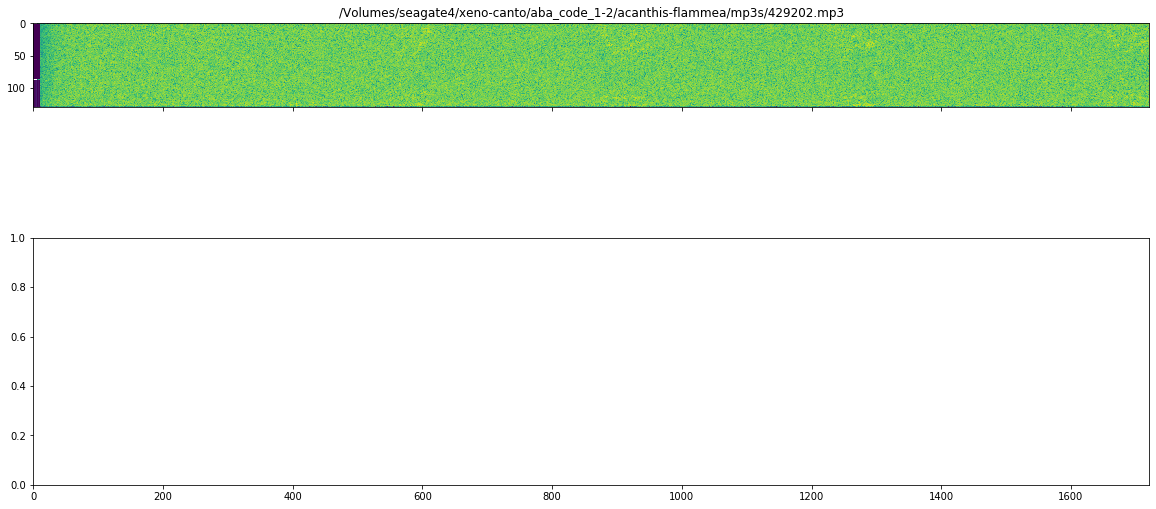

In [10]:
def plot_file(
    filename,
    thresh,
    duration = 5,
    smoothing_factor = 30,
    method = 'avg',
    nperseg = 256,
    noverlap = 0,
    ylim = (-100, 50)
):
    '''
    Plot a spectrogram and decibel information
    
    Plot a spectrogram and below it plot
    a display of which columns of the spectrogram
    include values over a threshold, thresh.
    Multiple plots can be plotted by passing
    a list to thresh.
    
    Args:
        filename: spectrogram to plot
        thresh (float or list): thresholds
            to plot beneath spectrogram. If float,
            plots one. If list, plots many.
    '''
    
    # Find average of whole file
    samples, sample_rate = load(filename, sr=22050)
    
    #smoothed_samples = gaussian_filter(np.abs(samples), sigma = smoothing_factor)
    smoothed_samples = window_energy(
        samples = samples,
        nperseg = nperseg*smoothing_factor,
        noverlap = noverlap,
    )
    
    # Create 5s spectrogram plot
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(20, 10))
    samples_5s = sample_chunk(samples, start=0, duration=duration, sample_rate=sample_rate)
    
    ''' 
    samples_db_5s = amplitude_to_db(samples)
    frequencies, times, spect = spectrogram(
        x = samples_5s,
        fs = sample_rate,
        nperseg = nperseg,
        noverlap = noverlap
    )
    axes[0].pcolormesh(times, frequencies, spect)
    axes[0].imshow(np.log(spect)[::-1])
    axes[0].set_title(filename)
    '''

    samples_5s_highpassed = butter_highpass_filter(data = samples_5s)
    samples_db_5s_highpassed = amplitude_to_db(samples_5s_highpassed)
    frequencies, times, spect2 = spectrogram(
        x = samples_db_5s_highpassed,
        fs = sample_rate,
        nperseg = nperseg,
        noverlap = noverlap
    )
    axes[0].pcolormesh(times, frequencies, spect2)
    axes[0].imshow(np.log(spect2)[::-1])
    axes[0].set_title(filename)


    # Create normalized 5s smoothed samples plot
    #smoothed_samples_5s = gaussian_filter(np.abs(samples_5s), sigma = smoothing_factor)
    smoothed_samples_5s = window_energy(
        samples = samples_5s,
        nperseg = nperseg*smoothing_factor,
        noverlap = noverlap*smoothing_factor
    )
    
    if method == 'avg':
        norm_factor = np.mean(smoothed_samples_5s)
        #windowed_samples_db_norm_factor = np.mean(windowed_samples_db_5s)
    elif method == 'max':
        norm_factor = np.max(smoothed_samples)
        #windowed_samples_db_norm_factor = np.max(windowed_samples_db)
    else:
        raise ValueError('"method" must be "avg" or "max"')
        
    spect_x_len = spect.shape[1]
    #xs_for_samples = np.linspace(start=0, stop=spect_x_len, num=len(windowed_samples_db_5s))
    #t_string = f'{method} of smoothed file: {windowed_samples_db_norm_factor}'
    xs_for_samples = np.linspace(start=0, stop=spect_x_len, num=len(smoothed_samples_5s))
    t_string = f'{method} of smoothed file: {norm_factor}'
    plot_samples_thresholds(
        plot_ax = axes[1],
        ref_ax = axes[0],
        xs = xs_for_samples,
        #ys = windowed_samples_db_5s - windowed_samples_db_norm_factor,
        ys = smoothed_samples_5s - norm_factor,
        title = t_string,
        thresh = thresh,
        ylim = ylim
    )
    
    #return windowed_samples_db
    return smoothed_samples_5s

aba_path = '/Volumes/seagate4/xeno-canto/aba_code_1-2/'
species_mp3_dirs = [os.path.join(aba_path, d, 'mp3s/') for d in os.listdir(aba_path) if os.path.isdir(os.path.join(aba_path, d))]
#random.seed(10) #bcch
#bcch_path = '/Volumes/seagate4/xeno-canto/aba_code_1-2/poecile-atricapillus/mp3s/' #bcch
#for file in [random.sample(os.listdir(bcch_path), 10)[-1]]: #bcch
t0 = time.time()
for mp3_dir in species_mp3_dirs[::70]: #full
    random.seed(10) #full
    file = random.choice(os.listdir(mp3_dir))
    filename = os.path.join(mp3_dir, file) #full
    
    #filename = os.path.join(bcch_path, file) #bcch
    returns = plot_file(
        filename,
        thresh = [0, 0.001, 0.002, 0.003], #list(np.linspace(20, -100, num=6)),
        method = 'avg',
        duration = 10,
        smoothing_factor = 1,
        nperseg = 256,
        noverlap = 128,
        ylim = (-.01, .01)
    )
    
    #'''
print(time.time() - t0)

In [7]:
bcch_path = '/Volumes/seagate4/xeno-canto/aba_code_1-2/poecile-atricapillus/mp3s/103201.mp3'